In [37]:
import numpy as np 
import pandas as pd 
import scipy.io

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

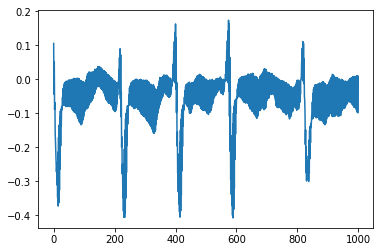

In [38]:
# Preparing the dataset

data = scipy.io.loadmat('D:/Sahil/Projects/swd/NNFL/Assignment 3/data.mat')
data = np.array(data['ecg_in_window'])
data = data/np.max(data)
# data = data.T

labels = scipy.io.loadmat('D:/Sahil/Projects/swd/NNFL/Assignment 3/labels.mat')
labels = np.array(labels['label'])

final_data = np.zeros([1000, 1001])


for i in range(1000):
    final_data[:,i] = data[:,i]

final_data[:,-1] = labels[:,-1]

np.random.shuffle(final_data)

final_data = np.array([final_data])
final_data = np.reshape(final_data, (1000,1001))

plt.plot(data[15])

In [39]:
train_data, test_data = final_data[:int(0.9*len(final_data))], final_data[int(0.9*len(final_data)):]

In [40]:
# Data Loader
class SignalsDataset(Dataset):

    def __init__(self, data, transform=None):
        self.dataframe = data
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        
        sample = {}
        
        sample['data'] = np.reshape(self.dataframe[idx,:1000], (1, 1000))
        sample['target'] = np.array(self.dataframe[idx,1000])
        
        sample['data'] = torch.from_numpy(sample['data'])
        sample['target'] = torch.from_numpy(sample['target'])
        
        if self.transform:
            sample = self.transform(np.array([sample]))

        return sample

In [41]:
batch_size = 100

In [42]:
train_data_obj = SignalsDataset(data=train_data)
test_data_obj = SignalsDataset(data=test_data)

train_loader = DataLoader(train_data_obj, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data_obj, batch_size=batch_size, shuffle=False, num_workers=0)

In [43]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.cnn_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=128, kernel_size=20, stride=1),
            nn.AvgPool1d(kernel_size=32, stride=1),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=20, stride=1),
            nn.AvgPool1d(kernel_size=10))
        
        self.linear = nn.Sequential(
            nn.Linear(5952, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid())
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = torch.squeeze(x)
        return x

In [44]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()
model = model.to(device)
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv1d(1, 128, kernel_size=(20,), stride=(1,))
    (1): AvgPool1d(kernel_size=(32,), stride=(1,), padding=(0,))
    (2): Conv1d(128, 64, kernel_size=(20,), stride=(1,))
    (3): AvgPool1d(kernel_size=(10,), stride=(10,), padding=(0,))
  )
  (linear): Sequential(
    (0): Linear(in_features=5952, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [45]:
def train(epoch):
    model.train()
    
    for i, sample in enumerate(train_loader):
        data = sample['data'].to(device)
        target = sample['target'].to(device) 
        data = data.float()
        target = target.float()
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()
        
    print("Training epoch {}".format(epoch+1))

In [46]:
# Testing function
def test():
        
        model.eval()
        
        test_loss = 0
        correct = 0
        
        for i, sample in enumerate(test_loader):

            data = sample['data'].to(device)
            target = sample['target'].to(device) 
            data = data.float()
            target = target.float()
            
            output = model(data)
            
            for j in range(len(target)):
                out = 0 if output[j].item() < 0.5 else 1
                if target[j].item() == out:
                    correct += 1
        
        print("Validation accuracy: ", correct/len(test_data))

In [47]:
for epoch in range(60):
    train(epoch)
    with torch.no_grad():
        test()

Training epoch 1
Validation accuracy:  0.47
Training epoch 2
Validation accuracy:  0.56
Training epoch 3
Validation accuracy:  0.51
Training epoch 4
Validation accuracy:  0.53
Training epoch 5
Validation accuracy:  0.54
Training epoch 6
Validation accuracy:  0.56
Training epoch 7
Validation accuracy:  0.52
Training epoch 8
Validation accuracy:  0.54
Training epoch 9
Validation accuracy:  0.56
Training epoch 10
Validation accuracy:  0.56
Training epoch 11
Validation accuracy:  0.54
Training epoch 12
Validation accuracy:  0.57
Training epoch 13
Validation accuracy:  0.55
Training epoch 14
Validation accuracy:  0.54
Training epoch 15
Validation accuracy:  0.55
Training epoch 16
Validation accuracy:  0.54
Training epoch 17
Validation accuracy:  0.55
Training epoch 18
Validation accuracy:  0.54
Training epoch 19
Validation accuracy:  0.54
Training epoch 20
Validation accuracy:  0.57
Training epoch 21
Validation accuracy:  0.56
Training epoch 22
Validation accuracy:  0.57
Training epoch 23
V